# TCSPC IRF shift test
Important part of TCSPC reconvolution is finding good initial guess of IRF shift.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from scipy.optimize import minimize
from scipy.signal import savgol_filter

## IRF Generation

In [ ]:
# Signal and IRF generation functions
def generate_signal_irf(time, irf_shift, noise_level=0.05, irf_params=(2, 0.2), signal_params=(1, 2, 3), amplitudes=(1, 0.5, 0.2)):
    irf_center, irf_width = irf_params
    
    # Generate IRF as a Gaussian
    irf = np.exp(-((time - irf_center)**2) / (2 * (irf_width**2)))  
    irf /= np.sum(irf)  # Normalize IRF
    
    # Generate a model signal as a sum of three exponentials
    tau1, tau2, tau3 = signal_params
    amp1, amp2, amp3 = amplitudes
    model_signal = amp1 * np.exp(-time / tau1) + amp2 * np.exp(-time / tau2) + amp3 * np.exp(-time / tau3)
    
    # Convolve the model signal with the IRF
    signal = np.convolve(model_signal, irf, mode='same')
    
    # Convert IRF shift from time units to index units
    time_resolution = np.mean(np.diff(time))
    index_shift = int(irf_shift / time_resolution)
    
    # Apply shift to the signal
    signal_shifted = np.roll(signal, index_shift)
    
    # Normalize the shifted signal
    signal_shifted /= np.sum(signal_shifted)
    
    # Add noise
    irf += np.random.normal(0, noise_level, irf.shape)
    signal_shifted += np.random.normal(0, noise_level, signal_shifted.shape)

    df_signal = pd.DataFrame({'Time': time, 'Photons': signal_shifted})
    df_irf = pd.DataFrame({'Time': time, 'Photons': irf})

    return df_signal, df_irf

In [ ]:
# Plot Generated IRF and Signal
def plot_generated_irf_signal(time, irf, signal, title='Generated IRF and Signal'):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(time, irf['Photons'], label='IRF')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.title('Instrument Response Function (IRF)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(time, signal['Photons'], label='Signal')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.title('Signal')
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
# Example usage
time = np.linspace(0, 50, 1000)
irf_shift = 5
irf_params = (2, 0.2)
signal_params = (1, 2, 3)
amplitudes = (1, 0.5, 0.2)
noise_level = 0.0005
signal, irf = generate_signal_irf(time, irf_shift, irf_params=irf_params, signal_params=signal_params, amplitudes=amplitudes, noise_level=noise_level)
plot_generated_irf_signal(time, irf, signal)

## IRF shift estimation methods

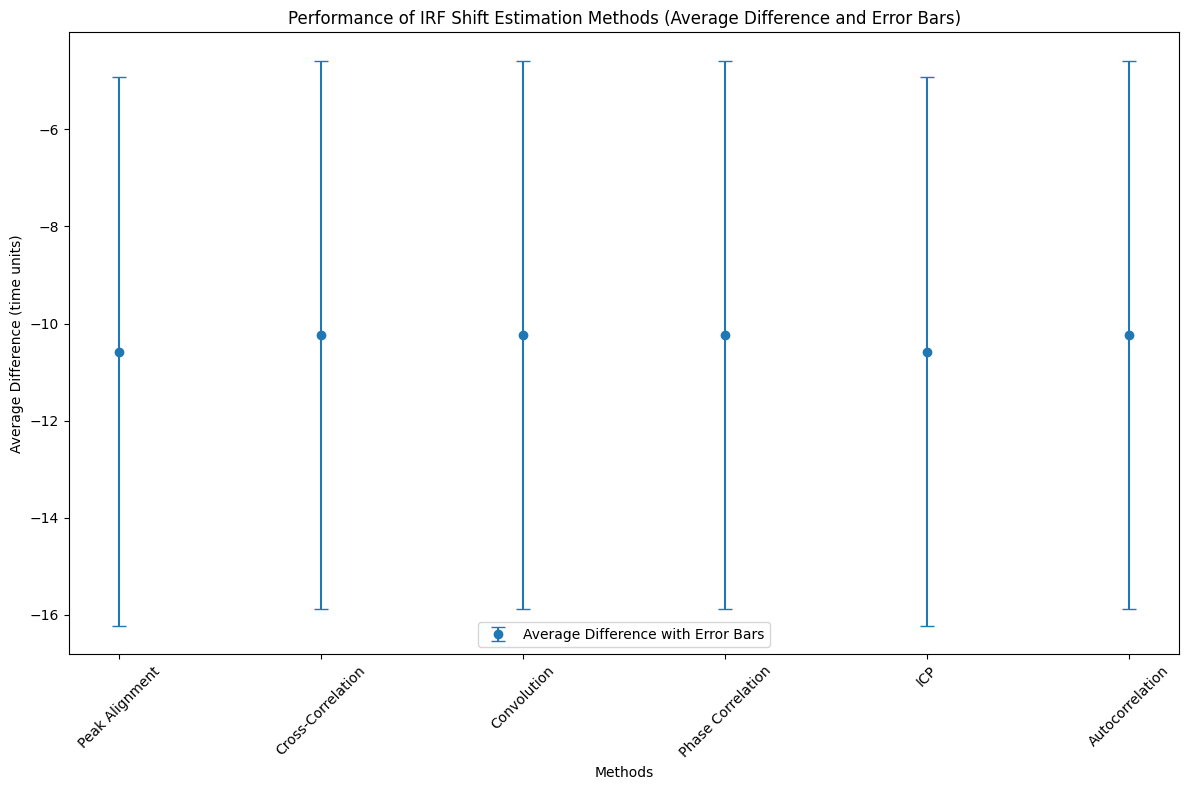

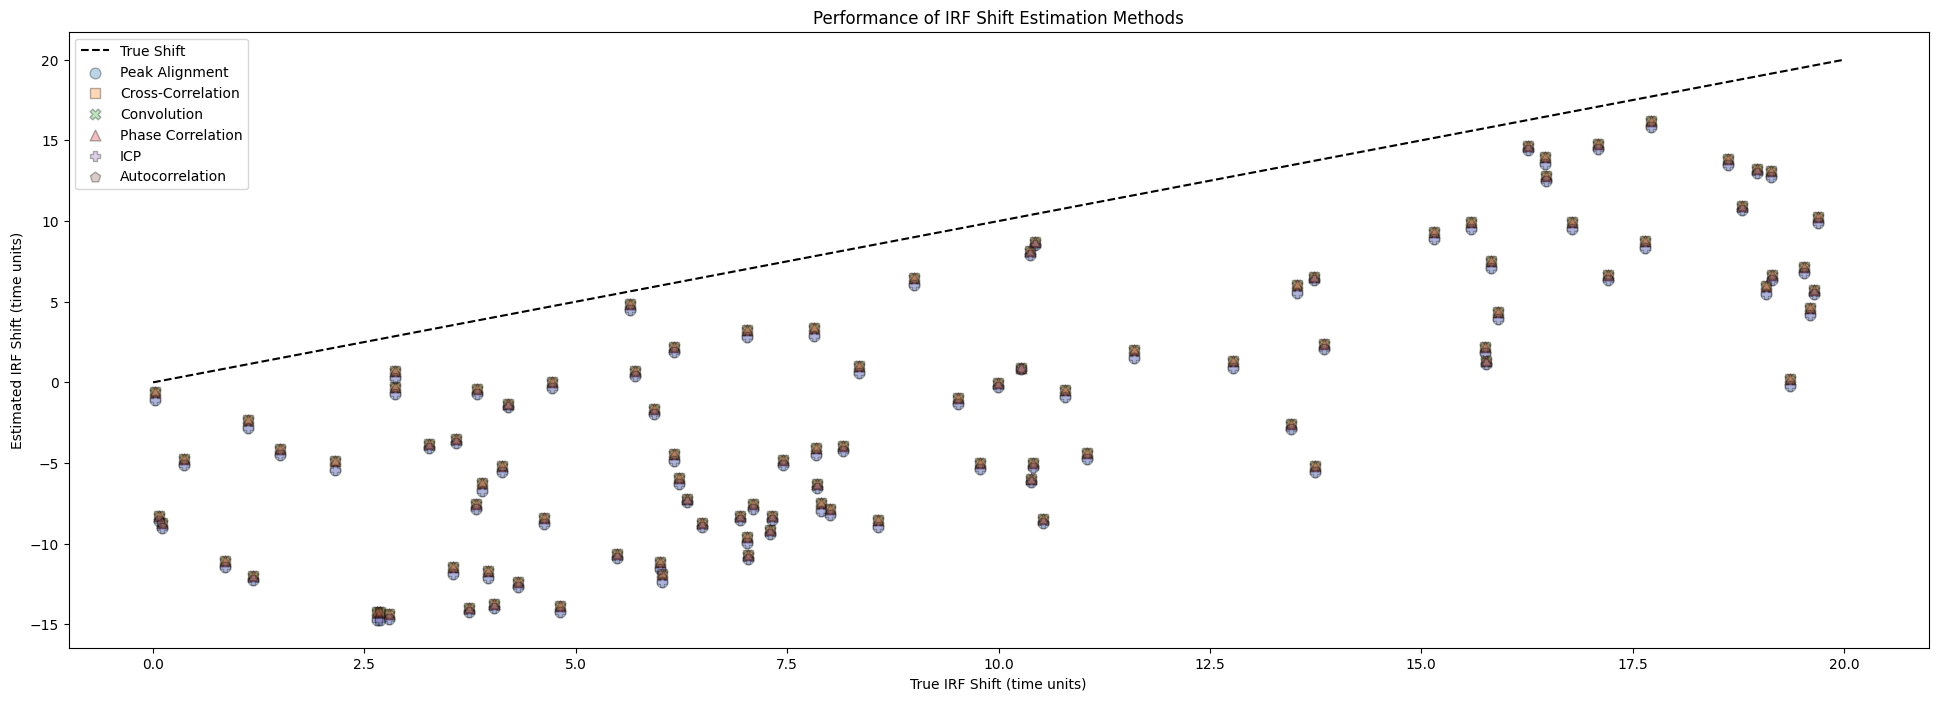

In [189]:



# Estimation methods
def estimate_irf_shift_peak_alignment(signal, irf):
    shift_index = np.argmax(signal['Photons']) - np.argmax(irf['Photons'])
    time_resolution = np.mean(np.diff(signal['Time']))
    return shift_index * time_resolution

def estimate_irf_shift_cross_correlation(signal, irf):
    cross_corr = np.correlate(signal['Photons'], irf['Photons'], mode='full')
    shift_index = np.argmax(cross_corr) - (len(irf['Photons']) - 1)
    time_resolution = np.mean(np.diff(signal['Time']))
    return shift_index * time_resolution


def estimate_irf_shift_convolution(signal, irf):
    convolution = np.convolve(signal['Photons'], irf['Photons'][::-1], mode='full')
    shift_index = np.argmax(convolution) - (len(irf['Photons']) - 1)
    time_resolution = np.mean(np.diff(signal['Time']))
    return shift_index * time_resolution

def estimate_irf_shift_phase_correlation(signal, irf):
    signal_fft = np.fft.fft(signal['Photons'])
    irf_fft = np.fft.fft(irf['Photons'])
    cross_power_spectrum = signal_fft * np.conj(irf_fft)
    cross_correlation = np.fft.ifft(cross_power_spectrum)
    
    # Correct handling of shifts and wrap-around
    shift_index = np.argmax(np.abs(cross_correlation))
    if shift_index > len(signal['Photons']) // 2:
        shift_index -= len(signal['Photons'])
    
    time_resolution = np.mean(np.diff(signal['Time']))
    return shift_index * time_resolution

def estimate_irf_shift_icp(signal, irf, max_iterations=100, tolerance=1e-6):
    shift = 0
    prev_shift = -np.inf
    iteration = 0
    time_resolution = np.mean(np.diff(irf['Time']))
    while abs(shift - prev_shift) > tolerance and iteration < max_iterations:
        prev_shift = shift
        shifted_irf = np.roll(irf['Photons'], int(shift / time_resolution))
        shift_diff = np.argmax(signal['Photons']) - np.argmax(shifted_irf)
        shift += shift_diff * time_resolution
        iteration += 1
    return shift

def estimate_irf_shift_autocorrelation(signal, irf):
    cross_corr = np.correlate(signal['Photons'], irf['Photons'], mode='full')
    shift_index = np.argmax(cross_corr) - (len(irf['Photons']) - 1)
    time_resolution = np.mean(np.diff(signal['Time']))
    return shift_index * time_resolution






## Analyze methods

In [ ]:
# Function to compare estimation methods and return results
def compare_estimation_methods(time, irf_shift, noise_level=0.05, irf_params=(2, 0.2), signal_params=(1, 2, 3), amplitudes=(1, 0.5, 0.2)):
    signal, irf = generate_signal_irf(time, irf_shift, noise_level, irf_params, signal_params, amplitudes)

    methods = {
        'Peak Alignment': estimate_irf_shift_peak_alignment,
        'Cross-Correlation': estimate_irf_shift_cross_correlation,
        'Convolution': estimate_irf_shift_convolution,
        'Phase Correlation': estimate_irf_shift_phase_correlation,
        'ICP': estimate_irf_shift_icp,
        'Autocorrelation': estimate_irf_shift_autocorrelation,
    }
    estimated_shifts = {name: method(signal, irf) for name, method in methods.items()}
    return estimated_shifts

# Function to analyze performance of estimation methods and plot scatter results
def analyze_estimation_methods(num_runs=100, time_length=50, num_points=1000, shift_range=(0, 20), noise_level_range=(0.00001, 0.0005), irf_params_range=((1, 20), (0.1, 0.3)), signal_params_range=((0.5, 1.5), (1.5, 2.5), (2.5, 3.5)), amplitudes_range=((0.5, 1.5), (0.3, 0.7), (0.1, 0.3))):
    time = np.linspace(0, time_length, num_points)
    true_shifts = np.random.uniform(shift_range[0], shift_range[1], num_runs)
    noise_levels = np.random.uniform(noise_level_range[0], noise_level_range[1], num_runs)
    irf_centers = np.random.uniform(irf_params_range[0][0], irf_params_range[0][1], num_runs)
    irf_widths = np.random.uniform(irf_params_range[1][0], irf_params_range[1][1], num_runs)
    tau1s = np.random.uniform(signal_params_range[0][0], signal_params_range[0][1], num_runs)
    tau2s = np.random.uniform(signal_params_range[1][0], signal_params_range[1][1], num_runs)
    tau3s = np.random.uniform(signal_params_range[2][0], signal_params_range[2][1], num_runs)
    amp1s = np.random.uniform(amplitudes_range[0][0], amplitudes_range[0][1], num_runs)
    amp2s = np.random.uniform(amplitudes_range[1][0], amplitudes_range[1][1], num_runs)
    amp3s = np.random.uniform(amplitudes_range[2][0], amplitudes_range[2][1], num_runs)
    
    all_shifts = {name: [] for name in compare_estimation_methods(time, 0).keys()}
    
    for i in range(num_runs):
        irf_params = (irf_centers[i], irf_widths[i])
        signal_params = (tau1s[i], tau2s[i], tau3s[i])
        amplitudes = (amp1s[i], amp2s[i], amp3s[i])
        true_shift = true_shifts[i]
        noise_level = noise_levels[i]
        
        estimated_shifts = compare_estimation_methods(time, true_shift, noise_level, irf_params, signal_params, amplitudes)
        for method, shift in estimated_shifts.items():
            all_shifts[method].append(shift)

    # Plot the scatter results
    plt.figure(figsize=(24, 8))
    method_markers = { 'Peak Alignment': 'o', 'Cross-Correlation': 's', 'Center of Mass': 'D', 'Convolution': 'X', 'Phase Correlation': '^', 'Maximum Likelihood': 'v', 'ICP': 'P', 'Autocorrelation': 'p'}
    for method, shifts in all_shifts.items():
        plt.scatter(true_shifts, shifts, label=method, alpha=0.3, s=60, edgecolors='k', marker=method_markers[method])
    
    
    plt.plot(shift_range, shift_range, 'k--', label='True Shift')
    plt.xlabel('True IRF Shift (time units)')
    plt.ylabel('Estimated IRF Shift (time units)')
    plt.title('Performance of IRF Shift Estimation Methods')
    plt.legend()
    plt.show()

# Function to analyze performance of estimation methods and plot average results with error bars
def analyze_estimation_methods_with_error_bars(num_runs=100, time_length=50, num_points=1000, shift_range=(0, 20), noise_level_range=(0.00001, 0.0005), irf_params_range=((1, 20), (0.1, 0.3)), signal_params_range=((0.5, 1.5), (1.5, 2.5), (2.5, 3.5)), amplitudes_range=((0.5, 1.5), (0.3, 0.7), (0.1, 0.3))):
    time = np.linspace(0, time_length, num_points)
    true_shifts = np.random.uniform(shift_range[0], shift_range[1], num_runs)
    noise_levels = np.random.uniform(noise_level_range[0], noise_level_range[1], num_runs)
    irf_centers = np.random.uniform(irf_params_range[0][0], irf_params_range[0][1], num_runs)
    irf_widths = np.random.uniform(irf_params_range[1][0], irf_params_range[1][1], num_runs)
    tau1s = np.random.uniform(signal_params_range[0][0], signal_params_range[0][1], num_runs)
    tau2s = np.random.uniform(signal_params_range[1][0], signal_params_range[1][1], num_runs)
    tau3s = np.random.uniform(signal_params_range[2][0], signal_params_range[2][1], num_runs)
    amp1s = np.random.uniform(amplitudes_range[0][0], amplitudes_range[0][1], num_runs)
    amp2s = np.random.uniform(amplitudes_range[1][0], amplitudes_range[1][1], num_runs)
    amp3s = np.random.uniform(amplitudes_range[2][0], amplitudes_range[2][1], num_runs)
    
    all_shifts = {name: [] for name in compare_estimation_methods(time, 0).keys()}
    
    for i in range(num_runs):
        irf_params = (irf_centers[i], irf_widths[i])
        signal_params = (tau1s[i], tau2s[i], tau3s[i])
        amplitudes = (amp1s[i], amp2s[i], amp3s[i])
        true_shift = true_shifts[i]
        noise_level = noise_levels[i]
        
        estimated_shifts = compare_estimation_methods(time, true_shift, noise_level, irf_params, signal_params, amplitudes)
        for method, shift in estimated_shifts.items():
            all_shifts[method].append(shift)
    
    avg_differences = {method: np.mean(np.array(shifts) - true_shifts) for method, shifts in all_shifts.items()}
    std_devs = {method: np.std(np.array(shifts) - true_shifts) for method, shifts in all_shifts.items()}

    # Plot the average results with error bars
    plt.figure(figsize=(12, 8))
    
    methods = list(avg_differences.keys())
    avg_diff = list(avg_differences.values())
    std_dev = list(std_devs.values())
    
    plt.errorbar(methods, avg_diff, yerr=std_dev, fmt='o', capsize=5, label='Average Difference with Error Bars')
    plt.xlabel('Methods')
    plt.ylabel('Average Difference (time units)')
    plt.title('Performance of IRF Shift Estimation Methods (Average Difference and Error Bars)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# # Example usage
analyze_estimation_methods_with_error_bars(num_runs=1000)
analyze_estimation_methods(num_runs=100)